# Assignment Introduction

##  High-Level Overview

This assignment is structured into three main stages to help you understand and build modern language models from scratch, fine-tune them effectively, and optimize them for deployment.

1. **Pretraining on TinyStories Subset**  
   We will begin by pretraining a language model from scratch using a subset of the TinyStories dataset (50,000 datapoints). This dataset contains short, simple English stories, which makes it ideal for foundational training on limited resources.

2. **LoRA Fine-Tuning on ROC stories**  
   After pretraining, we will fine-tune the model using **LoRA (Low-Rank Adaptation)** on the ROC dataset, which differs from story generation in the pretraining phase.

3. **QLoRA and Quantization**  
   In the final part, we will explore quantization and implement **QLoRA** to fine-tune a quantized version of the model, enabling efficient training and inference under constrained GPU environments.

***Please note: Do not use any other libraries unless specified***

**Submission Instruction**

1. Copy the notebook and replace blank with your name

2. Complete the notebook and make sure all cells have output

3. Download .ipyn (File->Download->.ipynb) and submit on Gradescope


**Running the notebook locally**

If you prefer to use your local compute, you can run a jupyter server locally, then copy the connection string (address and token).

Use the drop menu on the right top computation bar on Colab Notebook, and select connect to local runtime. Then paste your connection string and connect.


---

##  Detailed Overview

### Part 1: Pretraining from Scratch

- You will build the core components of a transformer-based language model, including:
  - Feedforward layers
  - Self-attention
  - Multi-head attention mechanisms

- These components will be assembled to form a functional LLM architecture.
- Due to limited GPU resources (e.g., free-tier Colab with T4 GPU), we will use a lightweight model with a few stacked layers to enable fast and feasible training.

### Part 2: LoRA Fine-Tuning

- Using the ROC dataset (which contains large-scale but unlabeled dataset as the training set. ROCStories is a collection of crowd-sourced completed ﬁve-sentence stories through Amazon Mechanical Turk (MTurk) workers.)
- LoRA helps reduce training costs by only learning low-rank updates, making it suitable for resource-constrained environments.

### Part 3: QLoRA and Model Quantization

- You will learn how to **quantize and dequantize** model weights, which allows for smaller memory footprint and faster computation.
- This part will culminate in applying **QLoRA**, where the model is quantized but still fine-tuned effectively using low-rank adapters.

---

##  Assignment Objective

The objective of this assignment is to help you gain a **deep understanding of how modern LLMs work**, including:

- Building them from scratch
- Fine-tuning them using parameter-efficient techniques
- Optimizing them for deployment using quantization

By completing this assignment, you'll grasp the fundamental design decisions behind state-of-the-art LLMs and understand what happens *behind the scenes* in many modern AI applications.


---


# Evaluation Rubric (Total: 40 Marks)

| Component                        | Marks |
|----------------------------------|-------|
| **1. Pretraining (TinyStories)** | 20    |
| **2. LoRA Fine-Tuning (RoC dataset)** | 10    |
| **3. QLoRA & Quantization**      | 10    |

---

>  **Note:** Partial credit will be awarded for incomplete implementations that show correct reasoning or partial functionality.



Install required libries

In [ ]:
!pip install transformers datasets scikit-learn tqdm matplotlib -q

!pip install bitsandbytes

!pip install rouge_score -q


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 MB 45.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
import torch
import numpy as np
import torch.nn as nn
import time
import torch.nn.functional as F


import math
from google.colab import drive
from torch.nn import CrossEntropyLoss
from transformers import AutoTokenizer, AutoModelForSequenceClassification,BitsAndBytesConfig
from datasets import load_dataset
from torch.optim import AdamW

from torch.utils.data import Dataset, DataLoader,Subset
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from torch.cuda.amp import GradScaler, autocast
import random

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



**Skip retraining**
**Ensure reproducibility**

 To avoid retraining the model every time the notebook is run, we can **save the model checkpoint after training and reload it later**.

Hardcoding the path to the saved model (e.g., `"./checkpoints/pretrained_model.pt"`) allows you to:


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
pretrain_save_path = '/content/drive/MyDrive/GenAI_Assignments/hw2/llm_pretrained.pt'
finetune_save_path = '/content/drive/MyDrive/GenAI_Assignments/hw2/llm_finetuned.pt'

Using device: cuda:0


**Loading the dataset**

In [ ]:
train_dataset = load_dataset("roneneldan/TinyStories", split="train[:50000]")
valid_dataset = load_dataset("roneneldan/TinyStories", split="validation[:400]")
test_dataset = load_dataset("roneneldan/TinyStories", split="validation[400:500]")
print(f"Train: {len(train_dataset)}, Valid: {len(valid_dataset)}, Test: {len(test_dataset)}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00004-2d5a1467fff108(…):   0%|          | 0.00/249M [00:00<?, ?B/s]

data/train-00001-of-00004-5852b56a2bd28f(…):   0%|          | 0.00/248M [00:00<?, ?B/s]

data/train-00002-of-00004-a26307300439e9(…):   0%|          | 0.00/246M [00:00<?, ?B/s]

data/train-00003-of-00004-d243063613e5a0(…):   0%|          | 0.00/248M [00:00<?, ?B/s]

data/validation-00000-of-00001-869c898b5(…):   0%|          | 0.00/9.99M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2119719 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/21990 [00:00<?, ? examples/s]

Train: 50000, Valid: 400, Test: 100


**Instance of a datapoint**

In [ ]:
print(train_dataset[0])

{'text': 'One day, a little girl named Lily found a needle in her room. She knew it was difficult to play with it because it was sharp. Lily wanted to share the needle with her mom, so she could sew a button on her shirt.\n\nLily went to her mom and said, "Mom, I found this needle. Can you share it with me and sew my shirt?" Her mom smiled and said, "Yes, Lily, we can share the needle and fix your shirt."\n\nTogether, they shared the needle and sewed the button on Lily\'s shirt. It was not difficult for them because they were sharing and helping each other. After they finished, Lily thanked her mom for sharing the needle and fixing her shirt. They both felt happy because they had shared and worked together.'}


**Plotting function**

In [ ]:
def plot_losses(train_losses_50, val_losses_50, title="Training and Validation Loss", save_path=None):
    """Plot training and validation losses every 50 batches."""
    plt.figure(figsize=(10, 6))
    x = [i * 50 for i in range(len(train_losses_50))]  # Batch indices: 0, 50, 100, ...
    plt.plot(x, train_losses_50, 'bo-', label="Training Loss", markersize=6, alpha=0.7)
    plt.plot(x, val_losses_50, 'ro-', label="Validation Loss", markersize=6, alpha=0.7)
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    if save_path:
        from google.colab import drive
        drive.mount('/content/drive', force_remount=True)
        plt.savefig(save_path)
        print(f"Plot saved to {save_path}")
    plt.show()

## Tokenization

We use the GPT-2 tokenizer to convert raw text into input token IDs for training, validation, and testing. Padding is applied for training/validation, but skipped for test data to allow flexible sequence lengths during generation.

- `tokenize_function`: Tokenizes and truncates to 256 tokens **with padding**, used for training and validation.
- `tokenize_function_no_padding`: Tokenizes and truncates **without padding**, used for test data.
- All attention masks are omitted here and will be handled separately in the `collate_fn`.

The `map()` function is used to apply these tokenization functions in a batched and efficient manner.


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token


def tokenize_function(examples):
  encodings = tokenizer(
        examples['text'],
        truncation=True,
        max_length=256,
        padding=True,# I changed it to True
        return_attention_mask=False
    )
  return {
        'input_ids': encodings['input_ids']
    }

def tokenize_function_no_padding(examples):
  encodings = tokenizer(
        examples['text'],
        truncation=True,
        max_length=256,
        padding=False, # No padding for test data
        return_attention_mask=False
    )
  return {
        'input_ids': encodings['input_ids']
    }


tokenized_dataset = train_dataset.map(
    tokenize_function,
    batched=True,
    batch_size=1000,
    remove_columns=['text']
)


tokenized_valid = valid_dataset.map(
    tokenize_function,
    batched=True,
    batch_size=1000,
    remove_columns=['text']
)

test_tokenized_dataset_no_padding = test_dataset.map(
    tokenize_function_no_padding,
    batched=True,
    batch_size=1000,
    remove_columns=['text']
)

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]



 **`collate_fn`**: Used for training and validation. It converts tokenized inputs to tensors and applies dynamic padding within each batch.
- **`collate_fn_no_padding`**: Used for the test set, but still applies padding for batch consistency (i.e., when generating sequences with batch size = 1).

These functions ensure that:
- Sequences are padded to the length of the longest input in the batch.
- Padding uses the tokenizer's `pad_token_id`.
- Token lists are safely converted to tensors if not already.

We then create `DataLoader`s for train, validation, and test sets using the appropriate batch size and collate function.


In [ ]:
def collate_fn(batch):
    input_ids = [item['input_ids'] if isinstance(item['input_ids'], torch.Tensor) else torch.tensor(item['input_ids'], dtype=torch.long) for item in batch]

    padded_input_ids = torch.nn.utils.rnn.pad_sequence(
        input_ids,
        batch_first=True,
        padding_value=tokenizer.pad_token_id
    )
    return {'input_ids': padded_input_ids}

def collate_fn_no_padding(batch):
    input_ids = [item['input_ids'] if isinstance(item['input_ids'], torch.Tensor) else torch.tensor(item['input_ids'], dtype=torch.long) for item in batch]

    padded_input_ids = torch.nn.utils.rnn.pad_sequence(
        input_ids,
        batch_first=True,
        padding_value=tokenizer.pad_token_id
    )
    return {'input_ids': padded_input_ids}



train_loader = DataLoader(
    tokenized_dataset,
    batch_size=32,
    shuffle=True,
    collate_fn=collate_fn
)
valid_loader = DataLoader(
    tokenized_valid,
    batch_size=32,
    collate_fn=collate_fn
)

test_loader = DataLoader(
    test_tokenized_dataset_no_padding,
    batch_size=1,
    collate_fn=collate_fn_no_padding
)

# Scaled Dot-Product Attention (***Need to Fill***)

This module computes attention weights that tell the model which input tokens to focus on. It's a core operation used in all Transformer models.

 How It Works (Steps)

Take input matrices: Queries (Q), Keys (K), and Values (V).

Compute attention scores as Q · Kᵀ / √dₖ.

Optionally mask out positions (for padding or causal attention).

Apply softmax to turn scores into probabilities.

Use these probabilities to compute a weighted sum of the values (V).

Return the final context vector and attention weights.

In [ ]:
#Fill it
class ScaledDotProductAttention(nn.Module):
    # YOUR CODE HERE
    def __init__(self, dropout=0.1):
        super().__init__()

    def forward(self,query, key, value, mask=None):
      d_k = query.size(-1)
      scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)

      if mask is not None:
        scores = scores.masked_fill(mask == 0, float('-inf'))

      p_attn = F.softmax(scores, dim=-1)

      return torch.matmul(p_attn, value), p_attn

# Multi-Head Attention (MHA) (***Need to Fill***)

Multi-head attention lets the model attend to different parts of the input simultaneously, capturing diverse patterns and relationships. It splits the input into multiple “heads”, applies attention in parallel, and then combines the results.

How It Works (Steps)

Linearly project the input x into queries (Q), keys (K), and values (V).

Split Q, K, V into multiple heads → shape: [batch, heads, seq_len, d_k].

Apply scaled dot-product attention to each head.

Concatenate the outputs of all heads.

Project back to the original dimension using a final linear layer.

In [ ]:
#Fill it
class MultiHeadAttention(nn.Module):
    # YOUR CODE HERE
    def __init__(self, num_heads, d_model):
      super().__init__()
      self.d_model = d_model
      self.num_heads = num_heads
      assert d_model % num_heads == 0
      self.dim_k = d_model // num_heads
      self.w_Q = nn.Linear(d_model, d_model)
      self.w_K = nn.Linear(d_model, d_model)
      self.w_V = nn.Linear(d_model, d_model)
      self.w_O = nn.Linear(d_model, d_model)
      self.attention = ScaledDotProductAttention()
      self.dropout = nn.Dropout(0.1)

    def forward(self, x, mask= None):
      nbatchs, seq_len, _ =  x.size()

      Q = self.w_Q(x)
      K = self.w_K(x)
      V = self.w_V(x)

      Q = Q.view(nbatchs, seq_len, self.num_heads, self.dim_k).transpose(1, 2)
      K = K.view(nbatchs, seq_len, self.num_heads, self.dim_k).transpose(1, 2)
      V = V.view(nbatchs, seq_len, self.num_heads, self.dim_k).transpose(1, 2)

      attention_output, attention_weights = self.attention(Q, K, V, mask)
      attention_output = attention_output.transpose(1, 2).contiguous().view(nbatchs, seq_len, self.num_heads * self.dim_k)
      output = self.w_O(attention_output)
      output = self.dropout(output)

      return output, attention_weights


In [ ]:
# Verification
mha_test = MultiHeadAttention(d_model=512, num_heads=8)
test_input = torch.randn(4, 10, 512)
output, _ = mha_test(test_input)
print(f"MHA Test Output Shape: {output.shape}") # Expected: [4, 10, 512]

MHA Test Output Shape: torch.Size([4, 10, 512])


# Position-wise Feedforward Network (FFN) (***Need to Fill***)

This module applies two linear layers with a ReLU in between, independently to each position in the input. It adds non-linearity and increases model capacity.

How It Works (Steps)

Apply a linear transformation to expand the dimension: d_model → d_ff.

Use ReLU activation to introduce non-linearity.

Apply dropout to regularize.

Project back to the original dimension: d_ff → d_model.

In [ ]:
#Fill it
class FeedForward(nn.Module):
    # YOUR CODE HERE
  def __init__(self,d_model, d_ff):
    super().__init__()
    self.linear1 = nn.Linear(d_model, d_ff)
    self.linear2 = nn.Linear(d_ff, d_model)
    self.relu_activation = nn.ReLU()
    self.dropout = nn.Dropout(0.1)

  def forward(self,x):
    x = self.linear1(x)
    x = self.relu_activation(x)
    x = self.dropout(x)
    x = self.linear2(x)
    return x

# This block is a simplified version of a Transformer decoder layer. It processes input by applying self-attention and a feedforward network, each followed by residual connections and normalization. (***Need to Fill***)

How It Works (Steps)

Apply masked multi-head self-attention to allow the model to attend to previous tokens only.

Use a residual connection and LayerNorm around the attention output.

Apply a position-wise feedforward network.

Use another residual connection and LayerNorm around the feedforward output.

In [ ]:
#Fill it
class DecoderBlock(nn.Module):
    # YOUR CODE HERE
    def __init__(self, d_model, num_heads, d_ff,dropout=0.1):
      super().__init__()
      self.self_attention = MultiHeadAttention(num_heads, d_model)
      self.feed_forward = FeedForward(d_model, d_ff)
      self.norm1 = nn.LayerNorm(d_model)
      self.norm2 = nn.LayerNorm(d_model)
      self.dropout = nn.Dropout(dropout)

    def forward(self ,x , mask):
      attention_output, _ = self.self_attention(x, mask)
      x = x + self.dropout(attention_output)
      x = self.norm1(x)

      ff_output = self.feed_forward(x)
      x = x + ff_output
      x = self.norm2(x)

      return x

A compact Transformer-style decoder for next-token prediction. It embeds tokens and positions, applies several DecoderBlocks with causal masking (no peeking at future tokens), then projects to vocabulary logits.


How It Works (Steps)

Embeddings: Look up token and positional embeddings, sum, then apply dropout.

Causal Mask:  a lower‑triangular mask [1,1,L,L]. If a padding attention_mask is provided [B,L], combine it so padded keys aren’t attended.

Decoder Stack: Pass through num_layers DecoderBlocks (self‑attention + FFN, each with residual + LayerNorm).

Final Layers: Apply a final LayerNorm and a linear head to get logits [B,L,V].



In [ ]:

class SimpleLanguageModel(nn.Module):
    def __init__(self, vocab_size, d_model=256, num_heads=8, num_layers=6, d_ff=1024, max_seq_len=512, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.max_seq_len = max_seq_len
        self.token_embedding = nn.Embedding(vocab_size, d_model)
        self.position_embedding = nn.Embedding(max_seq_len, d_model)
        self.layers = nn.ModuleList([DecoderBlock(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.ln_f = nn.LayerNorm(d_model)
        self.lm_head = nn.Linear(d_model, vocab_size)
        self.dropout = nn.Dropout(dropout)

    def create_causal_mask(self, seq_len, device):
        mask = torch.tril(torch.ones(seq_len, seq_len, device=device))
        return mask.unsqueeze(0).unsqueeze(0)

    def forward(self, input_ids,attention_mask=None, labels=None):

        batch_size, seq_len = input_ids.shape
        device = input_ids.device

        positions = torch.arange(seq_len, device=device).unsqueeze(0)
        token_emb = self.token_embedding(input_ids)
        pos_emb = self.position_embedding(positions)
        x = self.dropout(token_emb + pos_emb)

        casual_mask = self.create_causal_mask(seq_len, device)


        if attention_mask is not None:
          pad = attention_mask.unsqueeze(1).unsqueeze(2)
          mask = casual_mask * pad
        else:
          mask = casual_mask


        for layer in self.layers:
            x = layer(x, mask)

        x = self.ln_f(x)
        logits = self.lm_head(x)

        loss = None
        if labels is not None:
            shift_logits = logits[..., :-1, :].contiguous()
            shift_labels = labels[..., 1:].contiguous()

            loss_fn = nn.CrossEntropyLoss(ignore_index=-100)
            loss = loss_fn(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))

        return {"logits": logits, "loss": loss}

# How to Use the `train_model` Function (**Need to fill**)

This function trains a language model using PyTorch. Here's how it works and how you can adapt it:

---

### 1. Setup Inputs

Before calling `train_model(...)`, prepare the following:

- **`model`**: your initialized model (e.g., a Transformer).
- **`train_dataloader`**: batches of tokenized training examples.
- **`val_dataloader`**: batches of tokenized validation examples.
- **`optimizer`**: a PyTorch optimizer like `AdamW`.
- **`device`**: `"cuda"` or `"cpu"`, depending on availability.
- **`save_path`** *(optional)*: path to save the best-performing model.

---

###  2. Training Loop

- The model is trained over `num_epochs`.
- For each batch:
  - (Fro efficiency you can )Use mixed precision training (`autocast + GradScaler`).
  - (Fro efficiency you can ) Use gradient accumulation (e.g., 4 batches before `optimizer.step()`).
- Every 50 batches:
  - Evaluates on validation data.
  - Logs training and validation loss.

---

###  3. Validation and Saving

- After each epoch:
  - Computes average validation loss and perplexity.
  - If it's the best model so far, saves it to Google Drive (`save_path`).

---

###  Notes for Students

- Make sure `tokenizer.pad_token_id` is correctly defined.
- You can modify:
  - `num_epochs`: number of training rounds.
  - `gradient_accum_steps`: how many batches to accumulate gradients over.
  - `save_path`: file path to store the model.
- The function returns:
  - Best validation loss.
  - Training loss every 50 batches.
  - Validation loss every 50 batches.

---


###  Observational check

 20 epochs of pre training should give you validation data perplexity aroound 6 and test perplexity around 8


In [ ]:
@torch.no_grad()
def evaluate_model(model, dataloader, device):
    model.eval()
    total_loss = 0.0
    count = 0

    for batch in dataloader:
        input_ids = batch["input_ids"].to(device)
        labels = input_ids.clone()
        outputs = model(input_ids=input_ids, labels=labels)
        loss = outputs["loss"]
        total_loss += loss.item()
        count += 1

    model.train()  # switch back to training mode
    return total_loss / count

In [ ]:
import os
#Fill it

def train_model(model, train_dataloader, val_dataloader, optimizer, device,
                num_epochs=1, gradient_accum_steps=4, save_path=pretrain_save_path):
    # YOUR CODE HERE
    scaler = torch.amp.GradScaler()
    best_val_loss = float('inf')
    train_losses_50 = []
    val_losses_50 = []

    # checkpoint exists
    if os.path.exists(save_path):
        print(f"Resuming from checkpoint: {save_path}")
        checkpoint = torch.load(save_path, map_location=device)

        model.load_state_dict(checkpoint["model_state_dict"])
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
        scaler.load_state_dict(checkpoint["scaler_state_dict"])
        best_val_loss = checkpoint.get("best_val_loss", float("inf"))
        start_epoch = checkpoint.get("epoch", 0) + 1
        print(f"Resuming training from epoch {start_epoch}/{num_epochs}")
    else:
        print("Starting fresh training")
        start_epoch = 0

    model.to(device)
    model.train()

    for epoch in range(start_epoch, num_epochs):
        print(f"\n===== Epoch {epoch+1}/{num_epochs} =====")
        running_loss = 0.0

        for batch_id, batch in enumerate(tqdm(train_dataloader, desc=f"Epoch {epoch+1} Training")):
            input_ids = batch["input_ids"].to(device)
            labels = input_ids.clone()

            with torch.amp.autocast(device_type='cuda' if device.type == 'cuda' else 'cpu'):
                outputs = model(input_ids=input_ids, labels=labels)
                loss = outputs["loss"] / gradient_accum_steps

            scaler.scale(loss).backward()
            running_loss += loss.item() * gradient_accum_steps

            if (batch_id + 1) % gradient_accum_steps == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()

            if (batch_id + 1) % 50 == 0:
                avg_train_loss = running_loss / 50
                running_loss = 0.0

                val_loss = evaluate_model(model, val_dataloader, device)
                train_losses_50.append(avg_train_loss)
                val_losses_50.append(val_loss)

                print(f"Step [{batch_id+1}], Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}")

                # save best model within-epoch
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    torch.save({
                        "epoch": epoch,
                        "model_state_dict": model.state_dict(),
                        "optimizer_state_dict": optimizer.state_dict(),
                        "scaler_state_dict": scaler.state_dict(),
                        "best_val_loss": best_val_loss,
                    }, save_path)
                    print(f"Saved best model (Val Loss {val_loss:.4f}) → {save_path}")

        # validation & checkpoint at end of epoch
        val_loss = evaluate_model(model, val_dataloader, device)
        perplexity = math.exp(val_loss) if val_loss < 20 else float("inf")

        print(f"\n Epoch {epoch+1} Summary:")
        print(f"   Validation Loss: {val_loss:.4f}")
        print(f"   Perplexity (PPL): {perplexity:.4f}")

        # Save best model at epoch end
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save({
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "scaler_state_dict": scaler.state_dict(),
                "best_val_loss": best_val_loss,
            }, save_path)
        print(f"Saved best model of epoch {epoch+1} (Val Loss {val_loss:.4f})")

        model.train()

    return best_val_loss, train_losses_50, val_losses_50


In [ ]:
import torch, gc

gc.collect()
torch.cuda.empty_cache()

In [ ]:
vocab_size =  len(tokenizer)
d_model = 256
num_heads = 8
num_layers = 6
d_ff = 1024
max_seq_len = 256

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = SimpleLanguageModel(
        vocab_size=vocab_size,
        d_model=d_model,
        num_heads=num_heads,
        num_layers=num_layers,
        d_ff=d_ff,
        max_seq_len=max_seq_len).to(device)
optimizer = AdamW(model.parameters(), lr=5e-4)
best_val_loss, train_losses_50, val_losses_50 = train_model(model, train_loader, valid_loader, optimizer, device, num_epochs=15, save_path=pretrain_save_path)
plot_losses(train_losses_50, val_losses_50, title="pretraining loss")

cuda


In [ ]:
model = SimpleLanguageModel(
        vocab_size=vocab_size,
        d_model=d_model,
        num_heads=num_heads,
        num_layers=num_layers,
        d_ff=d_ff,
        max_seq_len=max_seq_len).to(device)

checkpoint = torch.load(pretrain_save_path, map_location=device)


model.load_state_dict(checkpoint["model_state_dict"])
print(f"Model loaded successfully from {pretrain_save_path}")

Model loaded successfully from /content/drive/MyDrive/GenAI_Assignments/hw2/llm_pretrained.pt


Evaluates the model on a given datase. Returns average loss and perplexity, measure of how confidently the model predicts the next token.

In [ ]:
def evaluate(model, dataloader, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attn = (input_ids != tokenizer.pad_token_id).long()
            labels = input_ids.clone()
            labels[attn == 0] = -100
            with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
              outputs = model(input_ids, attention_mask=attn, labels=labels)
              loss = outputs['loss']
            total_loss += loss.item()
    avg_loss = total_loss / len(dataloader)
    perplexity = torch.exp(torch.tensor(avg_loss))
    return avg_loss, perplexity


Generates continuations for each prompt in a batch using the model. Supports both argmax (greedy) and sampling with temperature. Returns the original prompt and its generated continuation for evaluation or display.

In [ ]:
def generate_predictions(model, loader, tokenizer, max_gen_tokens=50, sampling="argmax", temperature=1.0):
    model.eval()
    device = next(model.parameters()).device
    generated_texts = []
    prompt_texts = []

    for batch in loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = (input_ids != tokenizer.pad_token_id).long().to(device)
        prompt_len = min(input_ids.size(1), 50, getattr(model, "max_seq_len", input_ids.size(1)))
        prompt_ids = input_ids[:, :prompt_len]
        gen = prompt_ids.clone()
        gen_mask = attention_mask[:, :prompt_len]
        max_len = getattr(model, "max_seq_len", gen.size(1))

        for _ in range(max_gen_tokens):
            context = gen[:, -min(gen.size(1), max_len):]
            ctx_mask = gen_mask[:, -min(gen.size(1), max_len):]
            logits = model(context, attention_mask=ctx_mask)["logits"][:, -1, :]
            if sampling == "argmax":
                next_tok = torch.argmax(logits, dim=-1, keepdim=True)
            else:
                probs = F.softmax(logits / max(temperature, 1e-8), dim=-1)
                next_tok = torch.multinomial(probs, 1)
            gen = torch.cat([gen, next_tok], dim=-1)
            gen_mask = torch.cat([gen_mask, torch.ones_like(next_tok)], dim=-1)
            if next_tok.item() == tokenizer.eos_token_id:
                break

        for i in range(gen.size(0)):
            prompt_text = tokenizer.decode(prompt_ids[i].tolist(), skip_special_tokens=True).strip()
            prompt_texts.append(prompt_text)
            generated_tokens = gen[i, prompt_len:].tolist() if gen.size(1) > prompt_len else []
            generated_text = tokenizer.decode(generated_tokens, skip_special_tokens=True).strip()
            generated_texts.append(generated_text)

    return prompt_texts, generated_texts

In [ ]:
gold_texts_pretrained = [example['text'] for example in test_dataset]
print("Generating predictions for the pretrained model on TinyStories test set...")
prompt_texts_pretrained, generated_texts_pretrained = generate_predictions(model, test_loader, tokenizer)

num_examples_to_compare = min(len(generated_texts_pretrained), len(gold_texts_pretrained))

print("\nExamples (Pretrained Model on TinyStories Test Set):")
for i in range(min(5, num_examples_to_compare)): # Print first 5 examples
    print(f"--- Example {i+1} ---")
    print(f"Prompt: {prompt_texts_pretrained[i]}")
    print(f"Generated: {generated_texts_pretrained[i]}")
    print(f"Gold: {gold_texts_pretrained[i]}")
    print("-" * 20)

Generating predictions for the pretrained model on TinyStories test set...

Examples (Pretrained Model on TinyStories Test Set):
--- Example 1 ---
Prompt: Once upon a time, there was a happy family who loved to drink grape juice. One day, they went to a big store to buy some grape juice. They found a bottle of grape juice that was very special. The bottle was big and had
Generated: lots of juice.

The family was very happy. They ate the grape and drank it all up. Then they went home and ate the grape. The end.
Gold: Once upon a time, there was a happy family who loved to drink grape juice. One day, they went to a big store to buy some grape juice. They found a bottle of grape juice that was very special. The bottle was big and had a shiny label that said "brilliant wine". They bought the bottle and took it home.

The family opened the bottle and poured the wine into glasses. They tasted the wine and it was very yummy. But they decided that the wine was not for them. They wanted to retu

In [ ]:

avg_test_loss, test_perplexity = evaluate(model, test_loader, device)

print(f"Test Perplexity: {test_perplexity:.4f}")

/tmp/ipython-input-2064271313.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Test Perplexity: 7.9655


# Loading the pretrained model !!! Make it ready for finetune

##observational check your pretrained model structure should be like this in a printed format

```python
SimpleLanguageModel(
  (token_embedding): Embedding(50257, 256)
  (position_embedding): Embedding(256, 256)
  (layers): ModuleList(
    (0-5): 6 x DecoderBlock(
      (self_attention): MultiHeadAttention(
        (W_q): Linear(in_features=256, out_features=256, bias=False)
        (W_k): Linear(in_features=256, out_features=256, bias=False)
        (W_v): Linear(in_features=256, out_features=256, bias=False)
        (W_o): Linear(in_features=256, out_features=256, bias=False)
        (attention): ScaledDotProductAttention(
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (feed_forward): FeedForward(
        (linear1): Linear(in_features=256, out_features=1024, bias=True)
        (linear2): Linear(in_features=1024, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (ln_f): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (lm_head): Linear(in_features=256, out_features=50257, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)
```


In [ ]:
# Initialize the model with the same architecture parameters
model_for_lora = SimpleLanguageModel(
    vocab_size=vocab_size,
    d_model=d_model,
    num_heads=num_heads,
    num_layers=num_layers,
    d_ff=d_ff,
    max_seq_len=max_seq_len
).to(device)


model_checkpoint = torch.load(pretrain_save_path, map_location=device)
model_for_lora.load_state_dict(model_checkpoint["model_state_dict"])

print(f"Model loaded successfully from {pretrain_save_path}")
print(model_for_lora)

Model loaded successfully from /content/drive/MyDrive/GenAI_Assignments/hw2/llm_pretrained.pt
SimpleLanguageModel(
  (token_embedding): Embedding(50257, 256)
  (position_embedding): Embedding(256, 256)
  (layers): ModuleList(
    (0-5): 6 x DecoderBlock(
      (self_attention): MultiHeadAttention(
        (w_Q): Linear(in_features=256, out_features=256, bias=True)
        (w_K): Linear(in_features=256, out_features=256, bias=True)
        (w_V): Linear(in_features=256, out_features=256, bias=True)
        (w_O): Linear(in_features=256, out_features=256, bias=True)
        (attention): ScaledDotProductAttention()
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (feed_forward): FeedForward(
        (linear1): Linear(in_features=256, out_features=1024, bias=True)
        (linear2): Linear(in_features=1024, out_features=256, bias=True)
        (relu_activation): ReLU()
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (norm1): LayerNorm((256,), eps=1e-05, element



# Description — `LoRALinear` (**Need to Fill**)
`LoRALinear` augments a **frozen** linear layer with a **low‑rank trainable update**. The base weight `W` is kept fixed (`requires_grad=False`), while two small matrices `A ∈ ℝ^{in×r}` and `B ∈ ℝ^{r×out}` learn an efficient adaptation:
$$
\hat{W} = W \;+\; \underbrace{\alpha/r}_{\text{scaling}}\;\; A B
$$
This lets you fine‑tune large models by training only the low‑rank factors (`A`, `B`), dramatically reducing trainable parameters and memory.

- **Args:** `in_dim`, `out_dim`, rank `r` (default 16), scaling `alpha` (default 16).
- **Trainable params:** `A` and `B` only. Base layer `W` stays frozen.
- **Output:** `xW + x(AB) * (alpha/r)`.

---

##  How It Works (Steps)

1. **Initialize components**
   - Create a **frozen** base linear layer `W ∈ ℝ^{in×out}`.
   - Create trainable low‑rank factors:
     - `A ∈ ℝ^{in×r}` (random normal init)
     - `B ∈ ℝ^{r×out}` (zeros init)
   - Define a scaling factor `scaling = alpha / r`.

2. **Forward pass**
   - Compute the frozen projection:  
     `frozen_output = x @ W`
   - Compute the low‑rank update:  
     `lora_update = (x @ A @ B) * scaling`
   - **Combine** to form the adapted output:  
     `output = frozen_output + lora_update`.

3. **Training behavior**
   - **Only** `A` and `B` receive gradients and update; `W` remains constant.
   - Effective weight is implicitly `W + (alpha/r)·A·B`.

4. **Device safety**
   - `A` and `B` are moved to `x.device` during forward to avoid device mismatch.

---
---

##  Common Values for `r` and `alpha` in LoRA

| Hyperparameter | Meaning                                 | Typical Values       |
|----------------|------------------------------------------|----------------------|
| `r`            | Rank of the low-rank adapters (A, B)     | `r = 4`, `8`, `16`, or `32` |
| `alpha`        | Scaling factor to balance LoRA update    | Often equal to `r`, `2r`, or `32` |

### General Guidelines
- **`r = 4` or `8`**: Small models or low-resource settings.
- **`r = 16` or `32`**: Larger models or higher precision needed.
- **`alpha`** controls how strong the LoRA update is compared to the frozen weights:
  - Setting `alpha = r` gives unit scaling (`scaling = 1.0`).
  - Larger `alpha` (e.g., `alpha = 2r` or `alpha = 32`) **amplifies** the learned update.

###  Default Heuristic
A common and balanced choice is:
```python
r = 8
alpha = 16
scaling = alpha / r = 2.0


In [ ]:
#Fill it
class LoRALinear(nn.Module):
  def __init__(self, in_dim, out_dim, r=8, alpha=16):
    #Your code here
    super().__init__()

    self.r = r
    self.alpha = alpha
    self.scaling = alpha / r

    self.linear = nn.Linear(in_dim, out_dim, bias=True)

    for param in self.linear.parameters():
      param.requires_grad = False

    self.lora_A = nn.Parameter(torch.rand(in_dim, r) / math.sqrt(r))
    self.lora_B = nn.Parameter(torch.zeros(r, out_dim))

  def forward(self,x):

    frozen_output = self.linear(x)

    lora_A = self.lora_A.to(x.device)
    lora_B = self.lora_B.to(x.device)

    lora_update = x @ lora_A
    lora_update = lora_update @ lora_B
    lora_update = lora_update * self.scaling

    output = frozen_output + lora_update

    return output



In [ ]:
#verification

mha_test = MultiHeadAttention(d_model=512, num_heads=8)
test_input = torch.randn(4, 10, 512)
output, _ = mha_test(test_input)
print(f"MHA Test Output Shape: {output.shape}")
lora_test = LoRALinear(in_dim=512, out_dim=256)
lora_test.to(device)
test_input_device = test_input.to(device)
lora_output = lora_test(test_input_device)
print(f"LoRA Test Output Shape: {lora_output.shape}")
assert not lora_test.linear.weight.requires_grad
assert lora_test.lora_A.requires_grad
print("LoRA parameter grad status verified.")

MHA Test Output Shape: torch.Size([4, 10, 512])
LoRA Test Output Shape: torch.Size([4, 10, 256])
LoRA parameter grad status verified.


##  Applying LoRA to Attention Layers

The **original LoRA paper** proposed applying LoRA adapters only to the **query (`W_q`)** and **value (`W_v`)** projection layers inside self-attention modules. However, **later research** has shown that LoRA can be extended to **other linear layers** across the model including key layers, MLPs, and even output layers — for further parameter-efficient fine-tuning.

In this assignment, we follow the original approach and **replace only the query (`W_q`) and value (`W_v`) layers** in each self-attention block with `LoRALinear`.


In [ ]:

for param in model_for_lora.parameters():
    param.requires_grad = False

for layer in model_for_lora.layers:
    if hasattr(layer, 'self_attention') and isinstance(layer.self_attention, MultiHeadAttention):
        print(f"Processing layer: {layer}")
        original_w_q = layer.self_attention.w_Q
        if isinstance(original_w_q, nn.Linear) and not isinstance(original_w_q, LoRALinear):
            lora_w_q = LoRALinear(in_dim=original_w_q.in_features, out_dim=original_w_q.out_features, r=8)
            lora_w_q.linear.weight.data = original_w_q.weight.data.clone().to(device)
            lora_w_q.to(device)
            layer.self_attention.w_Q = lora_w_q
            print(f"Replaced {layer.self_attention}.W_q with LoRALinear")
        else:
            print(f"Skipped W_q replacement: {type(original_w_q)}")

        original_w_v = layer.self_attention.w_V
        if isinstance(original_w_v, nn.Linear) and not isinstance(original_w_v, LoRALinear):
            lora_w_v = LoRALinear(in_dim=original_w_v.in_features, out_dim=original_w_v.out_features, r=8)
            lora_w_v.linear.weight.data = original_w_v.weight.data.clone().to(device)
            lora_w_v.to(device)
            layer.self_attention.w_V = lora_w_v
            print(f"Replaced {layer.self_attention}.W_v with LoRALinear")
        else:
            print(f"Skipped W_v replacement: {type(original_w_v)}")



for name, param in model_for_lora.named_parameters():
    if 'lora_A' in name or 'lora_B' in name:
        param.requires_grad = True
    if 'lora_' in name:
        print(f"{name}: requires_grad={param.requires_grad}, device={param.device}")


trainable_params = sum(p.numel() for p in model_for_lora.parameters() if p.requires_grad)
print(f"\nNumber of trainable parameters with LoRA: {trainable_params:,}")

model_for_lora.to(device)
for name, param in model_for_lora.named_parameters():
    if param.device != device:

        param.data = param.data.to(device)

print(model_for_lora)


Processing layer: DecoderBlock(
  (self_attention): MultiHeadAttention(
    (w_Q): Linear(in_features=256, out_features=256, bias=True)
    (w_K): Linear(in_features=256, out_features=256, bias=True)
    (w_V): Linear(in_features=256, out_features=256, bias=True)
    (w_O): Linear(in_features=256, out_features=256, bias=True)
    (attention): ScaledDotProductAttention()
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (feed_forward): FeedForward(
    (linear1): Linear(in_features=256, out_features=1024, bias=True)
    (linear2): Linear(in_features=1024, out_features=256, bias=True)
    (relu_activation): ReLU()
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.1, inplace=False)
)
Replaced MultiHeadAttention(
  (w_Q): LoRALinear(
    (linear): Linear(in_features=256, out_features=256, bias=True)
  )
  (w_K): Linear(in_features=256, o


You should see now the LORA enhanced architecture looks like

```python
SimpleLanguageModel(
  (token_embedding): Embedding(50257, 256)
  (position_embedding): Embedding(256, 256)
  (layers): ModuleList(
    (0-5): 6 x DecoderBlock(
      (self_attention): MultiHeadAttention(
        (W_q): LoRALinear(
          (linear): Linear(in_features=256, out_features=256, bias=False)
        )
        (W_k): Linear(in_features=256, out_features=256, bias=False)
        (W_v): LoRALinear(
          (linear): Linear(in_features=256, out_features=256, bias=False)
        )
        (W_o): Linear(in_features=256, out_features=256, bias=False)
        (attention): ScaledDotProductAttention(
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (feed_forward): FeedForward(
        (linear1): Linear(in_features=256, out_features=1024, bias=True)
        (linear2): Linear(in_features=1024, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (ln_f): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (lm_head): Linear(in_features=256, out_features=50257, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)
```


##  Take aways:
- A standard decoder-only Transformer model.
- Each layer has:
  - **Multi-Head Attention**
  - **Feed-Forward Network (FFN)**
- All attention matrices (`W_q`, `W_k`, `W_v`, `W_o`) are standard `Linear` layers.
- **All parameters are updated** during training (high compute and memory cost).

---

##  What’s Different with LoRA?

**LoRA (Low-Rank Adaptation)** is a parameter-efficient fine-tuning method.

###  Key Changes:
- Only **`W_q`** and **`W_v`** are replaced with `LoRALinear` layers.
- LoRA adds **low-rank adapters** on top of **frozen** original weights.
- All other layers (`W_k`, `W_o`, FFN, LayerNorm) remain **unchanged and frozen**.

```text
Original:       W_q = Linear(in, out)              # trainable
LoRA version:   W_q = W_q_frozen + ΔW_q            # ΔW_q = A @ B (low-rank), trainable
```

###  Why Use LoRA?
-  **Efficiency**: Drastically fewer parameters to train.
-  **Modularity**: Fine-tuned LoRA weights can be stored separately.
-  **Flexibility**: Easy to adapt to new tasks/domains.

---

##  Summary Table

| Component     | Pretrained Model         | LoRA-enhanced Model     |
|---------------|---------------------------|--------------------------|
| `W_q`, `W_v`  | Fully trained `Linear`    | Frozen + LoRA adapters  |
| `W_k`, `W_o`  | Fully trained `Linear`    | Frozen                  |
| FFN, Norm     | Fully trained             | Frozen                  |
| **Training Cost** | High                    | Low                     |
| **Memory Usage**  | High                    | Low                     |

---

##  Key Takeaway
LoRA lets you **fine-tune large models efficiently** by injecting **small trainable adapters** into specific layers—without touching the rest of the model.


##  We need another datatset to Finetune

# Finetune dataset: ROC

The ROC dataset consists of  narrative language modeling and coherence/commonsense reasoning. We will use a subset of data for finetune (5k train,100 valid and 200 test datapoint)

In [ ]:
class rocDataset(Dataset):
    def __init__(self, hf_dataset, tokenizer, max_length=256):
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.data = hf_dataset
        self.vocab_size = len(tokenizer)

        print(f"Loaded {len(self.data)} examples from ROCStories")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]

        # Format: Use the 'story' field directly
        text = item.get('text', '').strip()

        token_count = len(self.tokenizer.encode(text, add_special_tokens=True))

        # Tokenize
        tokens = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        input_ids = tokens['input_ids'].squeeze()
        attention_mask = tokens['attention_mask'].squeeze()

        if torch.any(input_ids >= self.vocab_size) or torch.any(input_ids < 0):
            print(f"Warning: Invalid token ID found in sample {idx}. Max vocab ID: {self.vocab_size - 1}")

        return {
            'input_ids': input_ids,
            'labels': input_ids.clone(),
            'attention_mask': attention_mask,
            'data': item
        }

# Load mintujupally/ROCStories dataset
dataset = load_dataset("mintujupally/ROCStories")

train_val_dataset = dataset["train"].train_test_split(test_size=0.3, seed=42)  # 70% train, 30% temp
val_test_dataset = train_val_dataset["test"].train_test_split(test_size=0.833, seed=42)  # 5% val, 25% test

train_data = train_val_dataset["train"].select(range(5000))
val_data = val_test_dataset["train"].select(range(100))
test_data = val_test_dataset["test"].select(range(200))

print(f"Dataset split - Train: {len(train_data)}, Val: {len(val_data)}, Test: {len(test_data)}")

train_dataset = rocDataset(train_data, tokenizer)
val_dataset = rocDataset(val_data, tokenizer)
test_dataset = rocDataset(test_data, tokenizer)
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=False)

print("Training and evaluation complete!")
print("Training complete!")

README.md:   0%|          | 0.00/256 [00:00<?, ?B/s]

Repo card metadata block was not found. Setting CardData to empty.


train.txt:   0%|          | 0.00/18.1M [00:00<?, ?B/s]

test.txt: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/78528 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/19633 [00:00<?, ? examples/s]

Dataset split - Train: 5000, Val: 100, Test: 200
Loaded 5000 examples from ROCStories
Loaded 100 examples from ROCStories
Loaded 200 examples from ROCStories
Training and evaluation complete!
Training complete!


# ROC datapoint

In [ ]:
print(train_data[8])

{'text': "A magician visited Tim's elementary school to perform tricks. Tim was amazed by the magic tricks, and wanted to learn them himself. He researched magic tricks online to learn some that he could perform. After learning 5 different tricks, he could amaze all of his friends. Eventually Tim became a professional magician and could amaze anyone."}


# Fine-tuning a Pretrained Model with LoRA (**Need to Fill**)

This function `finetune_model_lora(...)` fine-tunes a pretrained LoRA-augmented model.

- **Inputs**:
  - `model`: pretrained model with LoRA layers
  - `train_dataloader`, `val_dataloader`: tokenized datasets
  - `optimizer`: e.g. AdamW for LoRA params
  - `device`: e.g. `cuda`
  - `num_epochs`: total training epochs
  - `gradient_accum_steps`: to simulate larger batch sizes
  - `save_path`: where to store the best model

- **Behavior**:
  
  - Applies gradient accumulation
  - Computes and logs train/val loss each epoch
  - Saves model if validation loss improves

- **Output**:
  - Lists of train and val losses per epoch


Starting fresh LoRA fine-tuning


/tmp/ipython-input-4007864437.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Epoch 1 Training:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 1 Validation:   0%|          | 0/25 [00:00<?, ?it/s]


Epoch 1 Summary:
   Training Loss: 4.9483
   Validation Loss: 4.7243
   Perplexity (PPL): 112.6543
Saved best model (Val Loss 4.7243) → /content/drive/MyDrive/GenAI_Assignments/hw2/llm_finetuned.pt


Epoch 2 Training:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 2 Validation:   0%|          | 0/25 [00:00<?, ?it/s]


Epoch 2 Summary:
   Training Loss: 4.8210
   Validation Loss: 4.6780
   Perplexity (PPL): 107.5600
Saved best model (Val Loss 4.6780) → /content/drive/MyDrive/GenAI_Assignments/hw2/llm_finetuned.pt


Epoch 3 Training:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 3 Validation:   0%|          | 0/25 [00:00<?, ?it/s]


Epoch 3 Summary:
   Training Loss: 4.7850
   Validation Loss: 4.6431
   Perplexity (PPL): 103.8671
Saved best model (Val Loss 4.6431) → /content/drive/MyDrive/GenAI_Assignments/hw2/llm_finetuned.pt


Epoch 4 Training:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 4 Validation:   0%|          | 0/25 [00:00<?, ?it/s]


Epoch 4 Summary:
   Training Loss: 4.7618
   Validation Loss: 4.6266
   Perplexity (PPL): 102.1675
Saved best model (Val Loss 4.6266) → /content/drive/MyDrive/GenAI_Assignments/hw2/llm_finetuned.pt


Epoch 5 Training:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 5 Validation:   0%|          | 0/25 [00:00<?, ?it/s]


Epoch 5 Summary:
   Training Loss: 4.7435
   Validation Loss: 4.6123
   Perplexity (PPL): 100.7128
Saved best model (Val Loss 4.6123) → /content/drive/MyDrive/GenAI_Assignments/hw2/llm_finetuned.pt


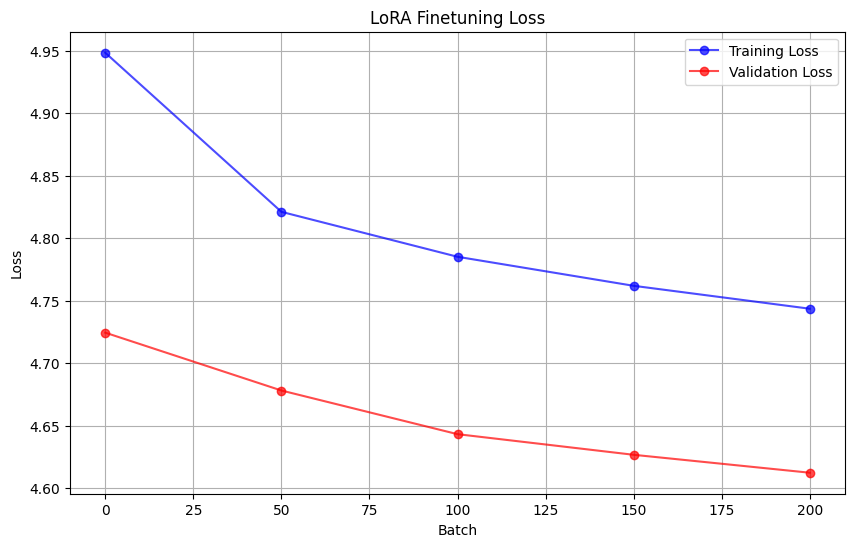

In [ ]:
lora_optimizer = AdamW(filter(lambda p: p.requires_grad, model_for_lora.parameters()), lr=2e-4)


def finetune_model_lora(model, train_dataloader, val_dataloader, optimizer, device, num_epochs=1, gradient_accum_steps=4, save_path='model.pt'):

    # Your code here
    scaler = GradScaler()
    best_val_loss = float('inf')
    epoch_train_losses = []
    epoch_val_losses = []

    if os.path.exists(save_path):
        print(f"Resuming from checkpoint: {save_path}")
        checkpoint = torch.load(save_path, map_location=device)
        model.load_state_dict(checkpoint["model_state_dict"])
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
        scaler.load_state_dict(checkpoint["scaler_state_dict"])
        best_val_loss = checkpoint.get("best_val_loss", float("inf"))
        start_epoch = checkpoint.get("epoch", 0) + 1
        print(f"Resuming training from epoch {start_epoch}/{num_epochs}")

    else:
        print("Starting fresh LoRA fine-tuning")
        start_epoch = 0

    model.to(device)

    for epoch in range(start_epoch, num_epochs):
        model.train()
        total_train_loss = 0.0
        train_steps = 0
        for batch_id, batch in enumerate(tqdm(train_dataloader, desc=f"Epoch {epoch+1} Training")):
          input_ids = batch['input_ids'].to(device)
          attention_mask = batch['attention_mask'].to(device)
          labels = batch['labels'].to(device)

          labels[attention_mask == 0] = -100

          with torch.amp.autocast(device_type='cuda' if device.type == 'cuda' else 'cpu'):
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs["loss"] / gradient_accum_steps

          scaler.scale(loss).backward()
          total_train_loss += loss.item() * gradient_accum_steps
          train_steps += 1
          if (batch_id + 1) % gradient_accum_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        avg_train_loss = total_train_loss / train_steps
        epoch_train_losses.append(avg_train_loss)

        model.eval()
        total_val_loss = 0.0
        val_steps = 0

        with torch.no_grad():
          for batch in tqdm(val_dataloader, desc=f"Epoch {epoch+1} Validation"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            # Mask padding tokens in labels
            labels[attention_mask == 0] = -100

            with torch.amp.autocast(device_type='cuda' if device.type == 'cuda' else 'cpu'):
              outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
              loss = outputs["loss"]

            total_val_loss += loss.item()
            val_steps += 1

        avg_val_loss = total_val_loss / val_steps
        epoch_val_losses.append(avg_val_loss)
        val_perplexity = math.exp(avg_val_loss) if avg_val_loss < 20 else float("inf")

        print(f"\nEpoch {epoch+1} Summary:")
        print(f"   Training Loss: {avg_train_loss:.4f}")
        print(f"   Validation Loss: {avg_val_loss:.4f}")
        print(f"   Perplexity (PPL): {val_perplexity:.4f}")

        if avg_val_loss < best_val_loss:
          best_val_loss = avg_val_loss
          torch.save({
              "epoch": epoch,
              "model_state_dict": model.state_dict(),
              "optimizer_state_dict": optimizer.state_dict(),
              "scaler_state_dict": scaler.state_dict(),
              "best_val_loss": best_val_loss,
          }, save_path)
          print(f"Saved best model (Val Loss {avg_val_loss:.4f}) → {save_path}")

        model.train()


    return epoch_train_losses, epoch_val_losses


epoch_train_losses, epoch_val_losses = finetune_model_lora(
    model_for_lora,
    train_dataloader,
    val_dataloader,
    lora_optimizer,
    device,
    num_epochs=5,
    save_path=finetune_save_path
)
plot_losses(epoch_train_losses, epoch_val_losses, title="LoRA Finetuning Loss")

In [ ]:
for i, layer in enumerate(model_for_lora.layers):
    if hasattr(layer, 'self_attention'):
        print(f"Layer {i} W_q type: {type(layer.self_attention.w_Q).__name__}")
        print(f"Layer {i} W_v type: {type(layer.self_attention.w_V).__name__}")

Layer 0 W_q type: LoRALinear
Layer 0 W_v type: LoRALinear
Layer 1 W_q type: LoRALinear
Layer 1 W_v type: LoRALinear
Layer 2 W_q type: LoRALinear
Layer 2 W_v type: LoRALinear
Layer 3 W_q type: LoRALinear
Layer 3 W_v type: LoRALinear
Layer 4 W_q type: LoRALinear
Layer 4 W_v type: LoRALinear
Layer 5 W_q type: LoRALinear
Layer 5 W_v type: LoRALinear


#Load the Adapters

In [ ]:
model_for_inference = SimpleLanguageModel(
    vocab_size=vocab_size,
    d_model=d_model,
    num_heads=num_heads,
    num_layers=num_layers,
    d_ff=d_ff,
    max_seq_len=max_seq_len
).to(device)
model_for_inference.load_state_dict(torch.load(pretrain_save_path, map_location=device)["model_state_dict"])

for layer in model_for_inference.layers:
    if hasattr(layer, 'self_attention') and isinstance(layer.self_attention, MultiHeadAttention):
        original_w_q = layer.self_attention.w_Q
        if isinstance(original_w_q, nn.Linear) and not isinstance(original_w_q, LoRALinear):
            lora_w_q = LoRALinear(in_dim=original_w_q.in_features, out_dim=original_w_q.out_features, r=8)
            lora_w_q.linear.weight.data = original_w_q.weight.data.clone().to(device)
            lora_w_q.to(device)
            layer.self_attention.w_Q = lora_w_q
        original_w_v = layer.self_attention.w_V
        if isinstance(original_w_v, nn.Linear) and not isinstance(original_w_v, LoRALinear):
            lora_w_v = LoRALinear(in_dim=original_w_v.in_features, out_dim=original_w_v.out_features, r=8)
            lora_w_v.linear.weight.data = original_w_v.weight.data.clone().to(device)
            lora_w_v.to(device)
            layer.self_attention.w_V = lora_w_v

# Step 2: Load finetuned weights
model_for_inference.load_state_dict(torch.load(finetune_save_path, map_location=device)["model_state_dict"])
model_for_inference.eval()
print(model_for_inference)

SimpleLanguageModel(
  (token_embedding): Embedding(50257, 256)
  (position_embedding): Embedding(256, 256)
  (layers): ModuleList(
    (0-5): 6 x DecoderBlock(
      (self_attention): MultiHeadAttention(
        (w_Q): LoRALinear(
          (linear): Linear(in_features=256, out_features=256, bias=True)
        )
        (w_K): Linear(in_features=256, out_features=256, bias=True)
        (w_V): LoRALinear(
          (linear): Linear(in_features=256, out_features=256, bias=True)
        )
        (w_O): Linear(in_features=256, out_features=256, bias=True)
        (attention): ScaledDotProductAttention()
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (feed_forward): FeedForward(
        (linear1): Linear(in_features=256, out_features=1024, bias=True)
        (linear2): Linear(in_features=1024, out_features=256, bias=True)
        (relu_activation): ReLU()
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affin

#Evaluate LORA

In [ ]:
def custom_collate_fn(batch):
    """
    Ensure 'data' field is a list of dictionaries.
    """
    return {
        'input_ids': torch.stack([item['input_ids'] for item in batch]),
        'labels': torch.stack([item['labels'] for item in batch]),
        'attention_mask': torch.stack([item['attention_mask'] for item in batch]),
        'data': [item['data'] for item in batch]  # List of raw dataset dictionaries
    }




@torch.no_grad()
def evaluate_ppl(model, dataloader, tokenizer, max_seq_len=256):

    model.eval()
    device = next(model.parameters()).device
    total_loss, n = 0.0, 0

    for batch in tqdm(dataloader, desc="Computing Test Perplexity"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # No instruction/context to mask for ROCStories; use full story text
        if attention_mask is not None:
            labels[attention_mask == 0] = -100

        with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs['loss']
            total_loss += loss.item()
        n += 1

    avg_loss = total_loss / n
    ppl = torch.exp(torch.tensor(avg_loss)).item()
    return avg_loss, ppl
def generate_predictions(model, tokenizer, test_dataset, max_gen_tokens=100, sampling="argmax", temperature=1.0, batch_size=16):
    model.eval()
    device = next(model.parameters()).device
    # Ensure all parameters are on the correct device
    for name, param in model.named_parameters():
        if param.device != device:
            print(f"Warning: Parameter {name} is on {param.device}, expected {device}")
            param.data = param.data.to(device)
    print("\n=== Generations on 5 Random Test Examples ===")
    indices = random.sample(range(len(test_dataset.data)), k=5)
    prompt_texts = []
    generated_texts = []
    max_seq_len = min(getattr(model, "max_seq_len", 256), 1024)
    for idx in indices:
        example = test_dataset.data[idx]
        # Use a prefix of the story (e.g., first 50% of tokens) as the prompt
        full_story = example['text'].strip()
        story_tokens = tokenizer.encode(full_story, add_special_tokens=False)
        prefix_length = len(story_tokens) // 2  # Take first half of the story
        prompt_text = tokenizer.decode(story_tokens[:prefix_length], skip_special_tokens=True).strip()
        # Tokenize prompt
        prompt_encoding = tokenizer(
            prompt_text,
            truncation=True,
            max_length=max_seq_len,
            return_tensors="pt",
            add_special_tokens=True
        )
        prompt_ids = prompt_encoding['input_ids'].to(device)
        attention_mask = prompt_encoding['attention_mask'].to(device) if 'attention_mask' in prompt_encoding else None
        gen_ids = prompt_ids.clone()
        for _ in range(max_gen_tokens):
            if gen_ids.size(1) >= max_seq_len:
                break
            ctx = gen_ids
            ctx_mask = attention_mask if attention_mask is not None else None
            with torch.no_grad():
                outputs = model(ctx, attention_mask=ctx_mask)
                logits = outputs['logits'][:, -1, :]
            if sampling == "argmax":
                next_tok = torch.argmax(logits, dim=-1, keepdim=True)
            else:
                probs = F.softmax(logits / max(temperature, 1e-8), dim=-1)
                next_tok = torch.multinomial(probs, 1)
            gen_ids = torch.cat([gen_ids, next_tok], dim=-1)
            if attention_mask is not None:
                attention_mask = torch.cat([attention_mask, torch.ones_like(next_tok)], dim=-1)
            if next_tok.item() == tokenizer.eos_token_id:
                break
        prompt_text_decoded = tokenizer.decode(prompt_ids[0], skip_special_tokens=True).strip()
        generated_text = tokenizer.decode(gen_ids[0, prompt_ids.size(1):], skip_special_tokens=True).strip()
        prompt_texts.append(prompt_text_decoded)
        generated_texts.append(generated_text)
        print(f"\n--- Example {len(prompt_texts)} ---")
        print(f"PROMPT:\n{prompt_text_decoded}")
        print(f"\nGENERATED:\n{generated_text}")
        print(f"\nREFERENCE RESPONSE:\n{full_story}")  # Use full story as reference
    # Evaluate perplexity
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn)
    test_loss, test_ppl = evaluate_ppl(model, test_loader, tokenizer, max_seq_len=max_seq_len)
    print(f"\n=== Test Perplexity ===\nLoss: {test_loss:.4f}  |  Perplexity: {test_ppl:.4f}")

    return prompt_texts, generated_texts


In [ ]:
prompts, generations = generate_predictions(
    model=model_for_inference,
    tokenizer=tokenizer,
    test_dataset=test_dataset,
    max_gen_tokens=256,
    sampling="argmax"
)


=== Generations on 5 Random Test Examples ===

--- Example 1 ---
PROMPT:
My dog likes to chase my cat. She'll hide behind some furniture until she sees the cat. When she sees it, she

GENERATED:
was very happy. She ran to the sofa and knocked on the door. The dog was so happy to see her cat. She gave her dog a big hug and a kiss. The dog was so happy and wagged its tail. The dog was now happy and wagged his tail. The dog was happy too.

REFERENCE RESPONSE:
My dog likes to chase my cat. She'll hide behind some furniture until she sees the cat. When she sees it, she'll jump out and chase it. Then the cat will start chasing the dog. After they get tired, they will nap together.

--- Example 2 ---
PROMPT:
Fernando lived alone in his house. Every day, he would wait to say hello to the mail man. One day, Fernando even had a glass of

GENERATED:
money. He was very sad and he couldn't afford to buy it. He went to the store to buy the money. He sold the money to the store and bought it. The ma

Computing Test Perplexity:   0%|          | 0/13 [00:00<?, ?it/s]

/tmp/ipython-input-772534875.py:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):



=== Test Perplexity ===
Loss: 4.6618  |  Perplexity: 105.8294


##  Can we reduce the model load for efficiency?

## Blockwise INT8 Quantization — Math Spec (**Need to fill**)

Let:

* Input tensor flattened to a vector $x \in \mathbb{R}^{N}$.
* Block size $B\in \mathbb{N}$.
* Number of blocks $K = \left\lceil \dfrac{N}{B} \right\rceil$.
* Padding $P = KB - N$.

We form a padded vector

$$
\tilde{x} = \begin{bmatrix} x \\ \underbrace{0,\dots,0}_{P\text{ zeros}} \end{bmatrix}\in\mathbb{R}^{KB},
$$

then reshape into blocks

$$
X \in \mathbb{R}^{K\times B},\qquad X_{k,i} = \tilde{x}_{kB+i},\quad k=0,\dots,K-1,\ i=0,\dots,B-1.
$$

## Per‑block scale

For each block $k$:

$$
a_k = \max_{0\le i < B} |X_{k,i}|,
$$

$$
a_k \leftarrow \max(a_k, \varepsilon)\quad(\text{avoid divide-by-zero; small }\varepsilon>0),
$$

$$
\alpha_k = \frac{a_k}{127}.
$$

Collect scales into $\boldsymbol{\alpha}\in \mathbb{R}^K$.

## Quantization (symmetric to int8 range, then stored as uint8)

Compute the signed int8 codebook value:

$$
q_{k,i}^{(\text{signed})}
= \operatorname{clip}\!\left(\operatorname{round}\!\left(\frac{X_{k,i}}{\alpha_k}\right),\,-127,\,127\right).
$$

Store as unsigned 8‑bit by adding an offset of 128:

$$
u_{k,i} = q_{k,i}^{(\text{signed})} + 128 \;\;\in\;\{0,\dots,255\}.
$$

Flatten $U=[u_{k,i}] \in \{0,\dots,255\}^{K\times B}$ back to a vector $\tilde{u}\in\{0,\dots,255\}^{KB}$ and drop padding to length $N$.
**Output of quantizer:**

* quantized tensor $u \in \{0,\dots,255\}^{N}$ (viewed in original shape),
* scales $\boldsymbol{\alpha}\in\mathbb{R}^{K}$.

> Notes:
>
> * $\operatorname{round}$ is ties‑to‑even (bankers’ rounding) as in PyTorch.
> * $\operatorname{clip}(z,a,b)=\min(\max(z,a),b)$.

## Dequantization

Given $u$ and the same block size $B$ and scales $\boldsymbol{\alpha}$:

1. Pad $u$ with the **quantized zero** value (128) to length $KB$:

$$
\tilde{u}=\begin{bmatrix} u \\ \underbrace{128,\dots,128}_{P\text{ times}} \end{bmatrix}.
$$

2. Reshape to blocks $U\in\{0,\dots,255\}^{K\times B}$ and convert back to signed codes:

$$
q_{k,i}^{(\text{signed})} = U_{k,i} - 128 \;\;\in\;[-128,127].
$$

(Your quantizer only produces $[-127,127]$; using 128 for padding yields exactly 0 after offset removal.)

3. Dequantize per block:

$$
\hat{X}_{k,i} = \alpha_k \cdot q_{k,i}^{(\text{signed})}.
$$

4. Flatten $\hat{X}$ to $\tilde{\hat{x}}\in\mathbb{R}^{KB}$ and remove padding to get $\hat{x}\in\mathbb{R}^{N}$.
   Reshape to the original tensor shape.

## Edge cases & properties

* **Empty input:** return empty `uint8` tensor and empty scale vector.
* **Zero block:** if all $X_{k,i}=0$, then $a_k=0\Rightarrow \alpha_k=\varepsilon$, and all $q_{k,i}^{(\text{signed})}=0$.
* **Error bound (per element):** with round‑to‑nearest,

  $$
  |X_{k,i} - \hat{X}_{k,i}| \le \tfrac{1}{2}\alpha_k = \frac{a_k}{254}.
  $$
* **Reproducibility:** Dequantization must reuse the **same** $B$ and $\boldsymbol{\alpha}$.

## Pseudocode summary (math → code)

1. Flatten, compute $K,P$, pad with zeros to $KB$.
2. Reshape to $(K,B)$.
3. $a_k \leftarrow \max_i |X_{k,i}|$; $\alpha_k \leftarrow \max(a_k,\varepsilon)/127$.
4. $q \leftarrow \operatorname{clip}(\operatorname{round}(X/\alpha),-127,127)$.
5. $u \leftarrow q + 128$; drop padding; reshape.
6. For dequant: pad with 128, reshape, $q \leftarrow u-128$, $\hat{X}\leftarrow q\cdot \alpha$, drop padding, reshape.




In [ ]:
#Fill it
def quantize_blockwise_int8(tensor, block_size=64):
    #Your code here
    original_shape = tensor.shape
    x = tensor.flatten().float()
    N = x.numel()
    K = math.ceil(N / block_size)
    P = K * block_size - N

    if P > 0:
      x_padded = torch.cat([x,torch.zeros(P, dtype= x.dtype, device= x.device)])
    else:
      x_padded = x

    X = x_padded.view(K, block_size)

    # Compute per-block scales
    epsilon = 1e-8
    a = torch.max(torch.abs(X), dim=1)[0]  # max |X_k,i| for each block k
    a = torch.clamp(a, min=epsilon)  # Avoid divide-by-zero
    alpha = a / 127.0  # Scale factor

    # Quantize: q_signed = clip(round(X / alpha), -127, 127)
    X_scaled = X / alpha.unsqueeze(1)  # Broadcast alpha to (K, 1)
    q_signed = torch.clamp(torch.round(X_scaled), -127, 127)

    # Convert to uint8: u = q_signed + 128
    u = (q_signed + 128).to(torch.uint8)

    # Flatten and remove padding
    u_flat = u.flatten()
    if P > 0:
        u_flat = u_flat[:N]

    # Reshape to original shape
    quantized = u_flat.view(original_shape)

    return quantized, alpha

def dequantize_blockwise_int8(quantized_tensor, scales, block_size=64):
    #Your code here


    original_shape = quantized_tensor.shape

    u = quantized_tensor.flatten()  # Flatten to vector
    N = u.numel()


    B = block_size
    K = scales.numel()  # Number of blocks
    P = K * B - N  # Padding needed

    # Pad with 128 (quantized zero) to KB
    if P > 0:
        u_padded = torch.cat([u, torch.full((P,), 128, dtype=torch.uint8, device=u.device)])
    else:
        u_padded = u

    # Reshape to blocks (K, B)
    U = u_padded.view(K, B)

    # Convert back to signed: q_signed = U - 128
    q_signed = U.to(torch.int16) - 128  # Use int16 to handle the range properly

    # Dequantize: X_hat = alpha * q_signed
    X_hat = scales.unsqueeze(1) * q_signed.float()  # Broadcast scales to (K, 1)

    # Flatten and remove padding
    x_hat_flat = X_hat.flatten()
    if P > 0:
        x_hat_flat = x_hat_flat[:N]

    # Reshape to original shape
    dequantized = x_hat_flat.view(original_shape)

    return dequantized

---

### Description — QLoRA Components (**Need to fill**)

This code enables **QLoRA**: it **quantizes** base linear layers to int8 (frozen) and adds **trainable LoRA adapters** on top of the **query (`W_q`) and value (`W_v`)** projections.

- **`LORAqLinearLayer`**: Wraps an existing linear/quantized linear. The wrapped layer stays **frozen**; a low‑rank adapter (`A: in×r`, `B: r×out`) learns updates. Output = `frozen(x) + (B(A(x)) * alpha/r)`.
- **`OurQuantizedLinear`**: Block‑wise INT8 weight quantization with per‑block scales (and optional bias quantization). On forward, weights/bias are **dequantized and detached**, ensuring no gradients through base weights.
- **`quantize_model_with_our_method(model, block_size)`**: Recursively replaces all `nn.Linear` with `OurQuantizedLinear`.
- **`apply_lora_adapters(model, r)`**: Freezes all params, then replaces only `self_attention.W_q` and `self_attention.W_v` with `LORAqLinearLayer`. Only LoRA params are trainable.

---

# How It Works (Step‑by‑Step)

1. **Quantize base model (frozen)**
   - Replace every `nn.Linear` with `OurQuantizedLinear`.
   - Store `(weight_quantized, weight_scales[, bias_quantized])` as buffers.
   - Forward: dequantize to FP32 **with `.detach()`**, then `linear(x, W_fp32[, b_fp32])`.

2. **Attach LoRA adapters to attention Q/V**
   - Freeze all parameters (`requires_grad=False`).
   - Find modules named like `*.self_attention.W_q` and `*.self_attention.W_v`.
   - Wrap each with `LORAqLinearLayer(linear=current, r, alpha)`.
   - Enable grads **only** for names containing `lora_` (the adapter weights).

3. **Training**
   - Backprop updates **only** into `lora_A`, `lora_B`.
   - Quantized base stays constant; effective layer behaves like  
     `W_frozen(x) + (alpha/r) · B(A(x))`.

4. **Sanity checks**
   - Prints how many layers were quantized and how many Q/V adapters were attached.
   - Warns if expected count (e.g., `6 layers × 2 = 12`) isn’t met.

---


1. **Quantize first**
   ```python
   model = quantize_model_with_our_method(model, block_size=64)


In [ ]:
#Fill it
class LORAqLinearLayer(nn.Module):
    def __init__(self, linear, r=8, alpha=16):
        #Your code here
        super().__init__()
        self.linear = linear

        # Get input/output dimensions
        if isinstance(linear, OurQuantizedLinear):
            in_features = linear.in_features
            out_features = linear.out_features
        else:  # nn.Linear
            in_features = linear.in_features
            out_features = linear.out_features

        self.in_features = in_features
        self.out_features = out_features
        self.r = r
        self.alpha = alpha
        self.scaling = alpha / r

        # Freeze the base layer
        for param in self.linear.parameters():
            param.requires_grad = False

        # Create trainable LoRA parameters
        # lora_A: [in_features, r]
        self.lora_A = nn.Parameter(torch.randn(in_features, r) / math.sqrt(r))

        # lora_B: [r, out_features]
        self.lora_B = nn.Parameter(torch.zeros(r, out_features))

    def forward(self, x):
        # Compute frozen base output
        frozen_output = self.linear(x)

        # Ensure LoRA parameters are on correct device
        lora_A = self.lora_A.to(x.device)
        lora_B = self.lora_B.to(x.device)

        # Compute LoRA update: x @ A @ B * scaling
        lora_output = torch.matmul(x, lora_A)  # [..., r]
        lora_output = torch.matmul(lora_output, lora_B)  # [..., out_features]
        lora_output = lora_output * self.scaling

        # Combine
        return frozen_output + lora_output

class OurQuantizedLinear(nn.Module):
    def __init__(self, original_layer, block_size=64):
        super().__init__()
        self.in_features = original_layer.in_features
        self.out_features = original_layer.out_features
        self.block_size = block_size

        weight_quantized, weight_scales = quantize_blockwise_int8(original_layer.weight, block_size)
        self.register_buffer('weight_quantized', weight_quantized)
        self.register_buffer('weight_scales', weight_scales)
        if original_layer.bias is not None:
            bias_absmax = torch.abs(original_layer.bias).max()
            self.bias_scale = bias_absmax / 127.0 if bias_absmax > 0 else 1.0
            bias_quantized = torch.round(original_layer.bias / self.bias_scale)
            self.register_buffer('bias_quantized', (bias_quantized.clamp(-127, 127) + 128).to(torch.uint8))
            self.has_bias = True
        else:
            self.has_bias = False

    def forward(self, x):

        weight_fp32 = dequantize_blockwise_int8(
            self.weight_quantized, self.weight_scales, self.block_size
        ).detach()

        output = torch.nn.functional.linear(x, weight_fp32)
        if self.has_bias:

            bias_fp32 = ((self.bias_quantized.float() - 128.0) * self.bias_scale).detach()
            output += bias_fp32
        return output


def apply_lora_adapters(model, r=8):

    for p in model.parameters():
        p.requires_grad = False

    replaced = 0
    for name, module in model.named_modules():
        if (isinstance(module, (nn.Linear, OurQuantizedLinear)) and
            any(s in name for s in ['self_attention.w_Q', 'self_attention.w_V'])):
            parts = name.split('.')
            parent = model
            for part in parts[:-1]:
                parent = getattr(parent, part)
            current = getattr(parent, parts[-1])
            if isinstance(current, LORAqLinearLayer):
                print(f"Warning: {name} is already a LORAqLinearLayer, skipping")
                continue
            lora = LORAqLinearLayer(current, r=r)
            setattr(parent, parts[-1], lora)
            print(f"Replaced {name} with LORAqLinearLayer")
            replaced += 1

    for name, param in model.named_parameters():
        param.requires_grad = 'lora_' in name

    print(f"Total LORAqLinearLayer replacements: {replaced}")
    if replaced != 12:  # 6 layers × 2 (W_q, W_v)
        print(f"Warning: Expected 12 replacements, got {replaced}")
    return model


def quantize_model_with_our_method(model, block_size=64):

    quantized_layers = 0

    def replace_layers(module, prefix=""):
        nonlocal quantized_layers

        for name, child in module.named_children():
            full_name = f"{prefix}.{name}" if prefix else name

            if isinstance(child, nn.Linear):
                quantized_layer = OurQuantizedLinear(child, block_size)
                setattr(module, name, quantized_layer)
                quantized_layers += 1
                print(f"  ✓ Our method - Quantized {full_name}: {child.weight.shape}")
            else:
                replace_layers(child, full_name)

    print(f"Quantizing with our method (block_size={block_size})...")
    replace_layers(model)
    print(f" Our method quantized {quantized_layers} layers")
    return model

#Test Quantization

In [ ]:

original_linear = nn.Linear(256, 256, bias=False)

original_size = original_linear.weight.numel() * original_linear.weight.element_size() / 1024 / 1024
print(f"Original size (MB): {original_size:.4f}")


quantized_layer = OurQuantizedLinear(original_linear, block_size=64)


quantized_size = (
    quantized_layer.weight_quantized.numel() * quantized_layer.weight_quantized.element_size() +
    quantized_layer.weight_scales.numel() * quantized_layer.weight_scales.element_size()
) / 1024 / 1024
print(f"Quantized size (MB): {quantized_size:.4f}")
print(f"Reduction: {original_size - quantized_size:.4f} MB")
print(f"Percentage reduction: {((original_size - quantized_size) / original_size * 100):.2f}%")

Original size (MB): 0.2500
Quantized size (MB): 0.0664
Reduction: 0.1836 MB
Percentage reduction: 73.44%


## Test LORAqLinearLayer

In [ ]:

original_linear = nn.Linear(256, 256, bias=False).to(device)
quantized_layer = OurQuantizedLinear(original_linear, block_size=64).to(device)
lora_layer = LORAqLinearLayer(quantized_layer, r=8).to(device)
x = torch.randn(4, 10, 256, requires_grad=True).to(device)
output = lora_layer(x)
loss = output.sum()
loss.backward()
print("LORAqLinearLayer backward pass successful")

LORAqLinearLayer backward pass successful


## Test OurQuantizedLinear

In [ ]:

original_linear = nn.Linear(256, 256, bias=False).to(device)
quantized_layer = OurQuantizedLinear(original_linear, block_size=64).to(device)
x = torch.randn(4, 10, 256, requires_grad=True).to(device)
output = quantized_layer(x)
loss = output.sum()
loss.backward()
print("OurQuantizedLinear backward pass successful")

OurQuantizedLinear backward pass successful


In [ ]:

model_for_Qlora = SimpleLanguageModel(
    vocab_size=vocab_size,
    d_model=d_model,
    num_heads=num_heads,
    num_layers=num_layers,
    d_ff=d_ff,
    max_seq_len=max_seq_len
).to(device)

# Load the saved state dictionary
model_for_Qlora.load_state_dict(torch.load(pretrain_save_path, map_location=device)["model_state_dict"])

print(f"Model loaded successfully from {pretrain_save_path}")


our_model = quantize_model_with_our_method(model_for_Qlora, 64)



Model loaded successfully from /content/drive/MyDrive/GenAI_Assignments/hw2/llm_pretrained.pt
Quantizing with our method (block_size=64)...
  ✓ Our method - Quantized layers.0.self_attention.w_Q: torch.Size([256, 256])
  ✓ Our method - Quantized layers.0.self_attention.w_K: torch.Size([256, 256])
  ✓ Our method - Quantized layers.0.self_attention.w_V: torch.Size([256, 256])
  ✓ Our method - Quantized layers.0.self_attention.w_O: torch.Size([256, 256])
  ✓ Our method - Quantized layers.0.feed_forward.linear1: torch.Size([1024, 256])
  ✓ Our method - Quantized layers.0.feed_forward.linear2: torch.Size([256, 1024])
  ✓ Our method - Quantized layers.1.self_attention.w_Q: torch.Size([256, 256])
  ✓ Our method - Quantized layers.1.self_attention.w_K: torch.Size([256, 256])
  ✓ Our method - Quantized layers.1.self_attention.w_V: torch.Size([256, 256])
  ✓ Our method - Quantized layers.1.self_attention.w_O: torch.Size([256, 256])
  ✓ Our method - Quantized layers.1.feed_forward.linear1: torch.

In [ ]:
modelqlora = apply_lora_adapters(our_model, r=8)
print(modelqlora)

modelqlora.to(device)

Replaced layers.0.self_attention.w_Q with LORAqLinearLayer
Replaced layers.0.self_attention.w_V with LORAqLinearLayer
Replaced layers.1.self_attention.w_Q with LORAqLinearLayer
Replaced layers.1.self_attention.w_V with LORAqLinearLayer
Replaced layers.2.self_attention.w_Q with LORAqLinearLayer
Replaced layers.2.self_attention.w_V with LORAqLinearLayer
Replaced layers.3.self_attention.w_Q with LORAqLinearLayer
Replaced layers.3.self_attention.w_V with LORAqLinearLayer
Replaced layers.4.self_attention.w_Q with LORAqLinearLayer
Replaced layers.4.self_attention.w_V with LORAqLinearLayer
Replaced layers.5.self_attention.w_Q with LORAqLinearLayer
Replaced layers.5.self_attention.w_V with LORAqLinearLayer
Total LORAqLinearLayer replacements: 12
SimpleLanguageModel(
  (token_embedding): Embedding(50257, 256)
  (position_embedding): Embedding(256, 256)
  (layers): ModuleList(
    (0-5): 6 x DecoderBlock(
      (self_attention): MultiHeadAttention(
        (w_Q): LORAqLinearLayer(
          (lin

SimpleLanguageModel(
  (token_embedding): Embedding(50257, 256)
  (position_embedding): Embedding(256, 256)
  (layers): ModuleList(
    (0-5): 6 x DecoderBlock(
      (self_attention): MultiHeadAttention(
        (w_Q): LORAqLinearLayer(
          (linear): OurQuantizedLinear()
        )
        (w_K): OurQuantizedLinear()
        (w_V): LORAqLinearLayer(
          (linear): OurQuantizedLinear()
        )
        (w_O): OurQuantizedLinear()
        (attention): ScaledDotProductAttention()
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (feed_forward): FeedForward(
        (linear1): OurQuantizedLinear()
        (linear2): OurQuantizedLinear()
        (relu_activation): ReLU()
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (ln_f): LayerNorm((256,), eps=1e-05, elementwi

# Verifying quantized LORA architecture

In [ ]:

for i, layer in enumerate(modelqlora.layers):
    w_q = layer.self_attention.w_Q
    w_v = layer.self_attention.w_V
    w_k = layer.self_attention.w_K
    print(f"Layer {i} W_q: {type(w_q).__name__}, linear: {type(w_q.linear).__name__}")
    print(f"Layer {i} W_v: {type(w_v).__name__}, linear: {type(w_v.linear).__name__}")
    print(f"Layer {i} W_k: {type(w_k).__name__}")

Layer 0 W_q: LORAqLinearLayer, linear: OurQuantizedLinear
Layer 0 W_v: LORAqLinearLayer, linear: OurQuantizedLinear
Layer 0 W_k: OurQuantizedLinear
Layer 1 W_q: LORAqLinearLayer, linear: OurQuantizedLinear
Layer 1 W_v: LORAqLinearLayer, linear: OurQuantizedLinear
Layer 1 W_k: OurQuantizedLinear
Layer 2 W_q: LORAqLinearLayer, linear: OurQuantizedLinear
Layer 2 W_v: LORAqLinearLayer, linear: OurQuantizedLinear
Layer 2 W_k: OurQuantizedLinear
Layer 3 W_q: LORAqLinearLayer, linear: OurQuantizedLinear
Layer 3 W_v: LORAqLinearLayer, linear: OurQuantizedLinear
Layer 3 W_k: OurQuantizedLinear
Layer 4 W_q: LORAqLinearLayer, linear: OurQuantizedLinear
Layer 4 W_v: LORAqLinearLayer, linear: OurQuantizedLinear
Layer 4 W_k: OurQuantizedLinear
Layer 5 W_q: LORAqLinearLayer, linear: OurQuantizedLinear
Layer 5 W_v: LORAqLinearLayer, linear: OurQuantizedLinear
Layer 5 W_k: OurQuantizedLinear


In [ ]:
w_q = modelqlora.layers[0].self_attention.w_Q
print(f"W_q.linear type: {type(w_q.linear).__name__}")
print(f"W_q.lora_A shape: {w_q.lora_A.shape}")
print(f"W_q.lora_B shape: {w_q.lora_B.shape}")
print(f"W_q.lora_A requires_grad: {w_q.lora_A.requires_grad}")
print(f"W_q.linear.weight_quantized dtype: {w_q.linear.weight_quantized.dtype}")

W_q.linear type: OurQuantizedLinear
W_q.lora_A shape: torch.Size([256, 8])
W_q.lora_B shape: torch.Size([8, 256])
W_q.lora_A requires_grad: True
W_q.linear.weight_quantized dtype: torch.uint8


#check trainable parameters

In [ ]:
trainable_params = sum(p.numel() for p in modelqlora.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params}")
for name, param in modelqlora.named_parameters():
    if param.requires_grad:
        print(f"Trainable: {name} (shape: {param.shape})")

Trainable parameters: 49152
Trainable: layers.0.self_attention.w_Q.lora_A (shape: torch.Size([256, 8]))
Trainable: layers.0.self_attention.w_Q.lora_B (shape: torch.Size([8, 256]))
Trainable: layers.0.self_attention.w_V.lora_A (shape: torch.Size([256, 8]))
Trainable: layers.0.self_attention.w_V.lora_B (shape: torch.Size([8, 256]))
Trainable: layers.1.self_attention.w_Q.lora_A (shape: torch.Size([256, 8]))
Trainable: layers.1.self_attention.w_Q.lora_B (shape: torch.Size([8, 256]))
Trainable: layers.1.self_attention.w_V.lora_A (shape: torch.Size([256, 8]))
Trainable: layers.1.self_attention.w_V.lora_B (shape: torch.Size([8, 256]))
Trainable: layers.2.self_attention.w_Q.lora_A (shape: torch.Size([256, 8]))
Trainable: layers.2.self_attention.w_Q.lora_B (shape: torch.Size([8, 256]))
Trainable: layers.2.self_attention.w_V.lora_A (shape: torch.Size([256, 8]))
Trainable: layers.2.self_attention.w_V.lora_B (shape: torch.Size([8, 256]))
Trainable: layers.3.self_attention.w_Q.lora_A (shape: torch.

In [ ]:
device = next(modelqlora.parameters()).device
mismatched = []
for name, param in modelqlora.named_parameters():
    if param.device != device:
        mismatched.append(name)
for name, buffer in modelqlora.named_buffers():
    if buffer.device != device:
        mismatched.append(name)
print(f"All tensors on {device}: {len(mismatched) == 0}")
if mismatched:
    print(f"Mismatched tensors: {mismatched}")

All tensors on cuda:0: True


###  Fine-tuning a QLoRA Model (**Need to Fill**)

This function `train_qlora(...)` fine-tunes a pretrained QLoRA model

- **Inputs**:
  - `model`: pretrained model with QLoRA adapters
  - `train_dataloader`, `val_dataloader`: tokenized datasets
  - `epochs`: number of training epochs
  - `lr`: learning rate for `AdamW`
  - `gradient_accum_steps`: number of steps before optimizer update

- **Behavior**:
  -
  - Accumulates gradients before updating (simulates large batch size)
  - Tracks average training and validation loss per epoch
  - Saves final model to `qlora_finetuned.pt`

- **Output**:
  - Two lists: `epoch_train_losses`, `epoch_val_losses`


In [ ]:
#Fill it
def train_qlora(model, train_dataloader, val_dataloader, epochs=1, lr=1e-4, gradient_accum_steps=4):

    #Your code here
    device = next(model.parameters()).device

    # Optimizer only for trainable (LoRA) parameters
    optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    scaler = torch.amp.GradScaler()

    epoch_train_losses = []
    epoch_val_losses = []

    model.train()

    for epoch in range(epochs):
        print(f"\n===== Epoch {epoch+1}/{epochs} =====")
        total_train_loss = 0.0
        train_steps = 0

        # Training loop
        for batch_id, batch in enumerate(tqdm(train_dataloader, desc=f"Epoch {epoch+1} Training")):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            # Mask padding tokens in labels
            labels[attention_mask == 0] = -100

            # Mixed precision training
            with torch.amp.autocast(device_type='cuda' if device.type == 'cuda' else 'cpu'):
                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs["loss"] / gradient_accum_steps

            scaler.scale(loss).backward()
            total_train_loss += loss.item() * gradient_accum_steps
            train_steps += 1

            # Optimizer step after accumulation
            if (batch_id + 1) % gradient_accum_steps == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()

        # Calculate average training loss
        avg_train_loss = total_train_loss / train_steps
        epoch_train_losses.append(avg_train_loss)

        # Validation loop
        model.eval()
        total_val_loss = 0.0
        val_steps = 0

        with torch.no_grad():
            for batch in tqdm(val_dataloader, desc=f"Epoch {epoch+1} Validation"):
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["labels"].to(device)

                # Mask padding tokens in labels
                labels[attention_mask == 0] = -100

                with torch.amp.autocast(device_type='cuda' if device.type == 'cuda' else 'cpu'):
                    outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                    loss = outputs["loss"]

                total_val_loss += loss.item()
                val_steps += 1

        # Calculate average validation loss
        avg_val_loss = total_val_loss / val_steps
        epoch_val_losses.append(avg_val_loss)
        val_perplexity = math.exp(avg_val_loss) if avg_val_loss < 20 else float("inf")

        print(f"\nEpoch {epoch+1} Summary:")
        print(f"   Training Loss: {avg_train_loss:.4f}")
        print(f"   Validation Loss: {avg_val_loss:.4f}")
        print(f"   Perplexity (PPL): {val_perplexity:.4f}")

        model.train()

    # Save final model
    save_path = 'qlora_finetuned.pt'
    torch.save({
        "model_state_dict": model.state_dict(),
        "epoch": epochs,
        "train_losses": epoch_train_losses,
        "val_losses": epoch_val_losses
    }, save_path)
    print(f"\nFinal model saved to {save_path}")

    return epoch_train_losses, epoch_val_losses


===== Epoch 1/5 =====


Epoch 1 Training:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 1 Validation:   0%|          | 0/25 [00:00<?, ?it/s]


Epoch 1 Summary:
   Training Loss: 4.9096
   Validation Loss: 4.7027
   Perplexity (PPL): 110.2479

===== Epoch 2/5 =====


Epoch 2 Training:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 2 Validation:   0%|          | 0/25 [00:00<?, ?it/s]


Epoch 2 Summary:
   Training Loss: 4.8101
   Validation Loss: 4.6639
   Perplexity (PPL): 106.0476

===== Epoch 3/5 =====


Epoch 3 Training:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 3 Validation:   0%|          | 0/25 [00:00<?, ?it/s]


Epoch 3 Summary:
   Training Loss: 4.7783
   Validation Loss: 4.6298
   Perplexity (PPL): 102.4969

===== Epoch 4/5 =====


Epoch 4 Training:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 4 Validation:   0%|          | 0/25 [00:00<?, ?it/s]


Epoch 4 Summary:
   Training Loss: 4.7552
   Validation Loss: 4.6299
   Perplexity (PPL): 102.5064

===== Epoch 5/5 =====


Epoch 5 Training:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 5 Validation:   0%|          | 0/25 [00:00<?, ?it/s]


Epoch 5 Summary:
   Training Loss: 4.7449
   Validation Loss: 4.6194
   Perplexity (PPL): 101.4373

Final model saved to qlora_finetuned.pt

Plotting batch-wise training and validation loss...


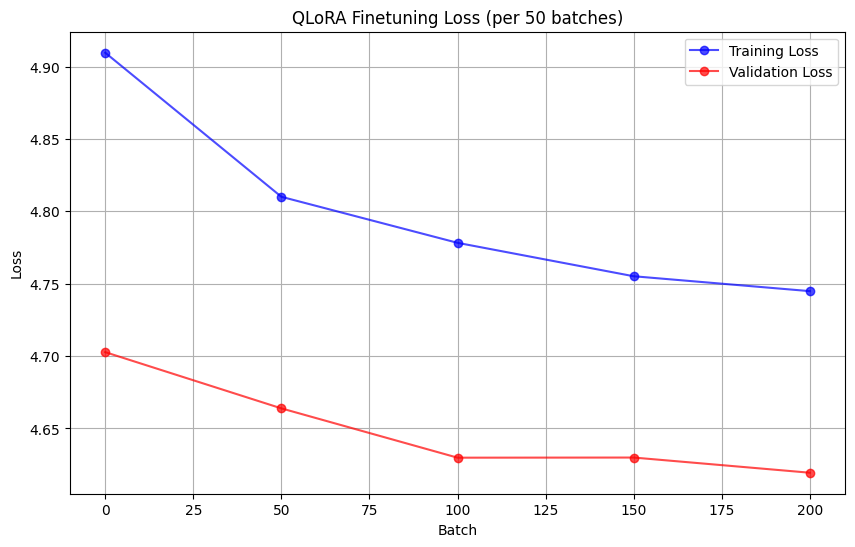

In [ ]:
train_losses, val_losses = train_qlora(modelqlora, train_dataloader, val_dataloader, epochs=5, lr=2e-4)
print("\nPlotting batch-wise training and validation loss...")
plot_losses(train_losses, val_losses, title="QLoRA Finetuning Loss (per 50 batches)")

In [ ]:
model_for_inference = SimpleLanguageModel(
    vocab_size=vocab_size,
    d_model=d_model,
    num_heads=num_heads,
    num_layers=num_layers,
    d_ff=d_ff,
    max_seq_len=max_seq_len
).to(device)
model_for_inference.load_state_dict(torch.load(pretrain_save_path, map_location=device)["model_state_dict"])

our_model_inf = quantize_model_with_our_method(model_for_inference, 64)
modelqlora_inf = apply_lora_adapters(our_model_inf, r=8)

# Load finetuned weights
modelqlora_inf.load_state_dict(torch.load("qlora_finetuned.pt", map_location=device)["model_state_dict"])
modelqlora_inf.eval()

Quantizing with our method (block_size=64)...
  ✓ Our method - Quantized layers.0.self_attention.w_Q: torch.Size([256, 256])
  ✓ Our method - Quantized layers.0.self_attention.w_K: torch.Size([256, 256])
  ✓ Our method - Quantized layers.0.self_attention.w_V: torch.Size([256, 256])
  ✓ Our method - Quantized layers.0.self_attention.w_O: torch.Size([256, 256])
  ✓ Our method - Quantized layers.0.feed_forward.linear1: torch.Size([1024, 256])
  ✓ Our method - Quantized layers.0.feed_forward.linear2: torch.Size([256, 1024])
  ✓ Our method - Quantized layers.1.self_attention.w_Q: torch.Size([256, 256])
  ✓ Our method - Quantized layers.1.self_attention.w_K: torch.Size([256, 256])
  ✓ Our method - Quantized layers.1.self_attention.w_V: torch.Size([256, 256])
  ✓ Our method - Quantized layers.1.self_attention.w_O: torch.Size([256, 256])
  ✓ Our method - Quantized layers.1.feed_forward.linear1: torch.Size([1024, 256])
  ✓ Our method - Quantized layers.1.feed_forward.linear2: torch.Size([256, 1

SimpleLanguageModel(
  (token_embedding): Embedding(50257, 256)
  (position_embedding): Embedding(256, 256)
  (layers): ModuleList(
    (0-5): 6 x DecoderBlock(
      (self_attention): MultiHeadAttention(
        (w_Q): LORAqLinearLayer(
          (linear): OurQuantizedLinear()
        )
        (w_K): OurQuantizedLinear()
        (w_V): LORAqLinearLayer(
          (linear): OurQuantizedLinear()
        )
        (w_O): OurQuantizedLinear()
        (attention): ScaledDotProductAttention()
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (feed_forward): FeedForward(
        (linear1): OurQuantizedLinear()
        (linear2): OurQuantizedLinear()
        (relu_activation): ReLU()
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (ln_f): LayerNorm((256,), eps=1e-05, elementwi

In [ ]:
prompt_texts, generated_texts = generate_predictions(
    model=modelqlora_inf,
    tokenizer=tokenizer,
    test_dataset=test_dataset,
    max_gen_tokens=100,
    sampling="argmax"
)


=== Generations on 5 Random Test Examples ===

--- Example 1 ---
PROMPT:
Baylee was playing with her brother one afternoon. Her brother was not playing fair. Baylee found a ladybug crawling on

GENERATED:
the floor. She was very happy with her brother. She decided to take her brother to the park. She was glad she was able to play with her brother. They played together and had lots of fun.

REFERENCE RESPONSE:
Baylee was playing with her brother one afternoon. Her brother was not playing fair. Baylee found a ladybug crawling on the window. She picked up the ladybug. Baylee walked over and shoved the ladybud in her brother's mouth.

--- Example 2 ---
PROMPT:
Tom hated reading. His teacher talked to him about it. The teacher found out what Tom

GENERATED:
was wrong. Tom was sad. He had to go to the hospital. He was very sad. He went to the hospital. Tom was very sad. He had to go to the hospital. Tom learned a lesson about his teacher. He learned to be more careful when he was sick.

REF

Computing Test Perplexity:   0%|          | 0/13 [00:00<?, ?it/s]

/tmp/ipython-input-772534875.py:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):



=== Test Perplexity ===
Loss: 4.6689  |  Perplexity: 106.5803
